# Spline-Based Guessing Strategy

This notebook explores a guessing strategy that uses spline interpolation through the probability distribution points to create a continuous PDF for sampling guesses.

## The Challenge
Given a discrete probability distribution:
- Values: {0, 0.25, 0.5, 0.75, 1}
- Probabilities: {0.05, 0.2, 0.5, 0.2, 0.05}

We want to create a spline interpolation through these points and use it as a continuous probability density function to sample our guesses.

## Strategy Overview
1. Create spline interpolation through (value, probability) points
2. Normalize the spline to make it a proper PDF
3. Sample guesses from this spline-based PDF
4. Calculate expected error against the true discrete distribution

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate
from scipy.optimize import minimize_scalar
import pandas as pd
from typing import Callable, Tuple

np.random.seed(42)
plt.style.use('seaborn-v0_8')

## Define the True Distribution

In [14]:
# True discrete distribution
true_values = np.array([0, 0.25, 0.5, 0.75, 1.0])
true_probs = np.array([0.05, 0.2, 0.5, 0.2, 0.05])

print(f"True values: {true_values}")
print(f"True probabilities: {true_probs}")
print(f"Sum of probabilities: {true_probs.sum()}")

True values: [0.   0.25 0.5  0.75 1.  ]
True probabilities: [0.05 0.2  0.5  0.2  0.05]
Sum of probabilities: 1.0


## Create Spline Interpolation

In [15]:
def create_spline_pdf(values: np.ndarray, probs: np.ndarray, kind: str = 'cubic') -> Callable:
    """
    Create a spline interpolation through (value, probability) points
    and normalize it to be a proper PDF.
    """
    # Create spline interpolation
    spline = interpolate.interp1d(values, probs, kind=kind, 
                                  bounds_error=False, fill_value=0)
    
    # Define the domain for normalization
    x_min, x_max = values.min(), values.max()
    
    # Calculate normalization constant
    normalization_constant, _ = integrate.quad(spline, x_min, x_max)
    
    def normalized_spline_pdf(x):
        return spline(x) / normalization_constant
    
    return normalized_spline_pdf, normalization_constant

# Create different types of spline PDFs
spline_pdf_cubic, norm_const_cubic = create_spline_pdf(true_values, true_probs, 'cubic')
spline_pdf_quadratic, norm_const_quadratic = create_spline_pdf(true_values, true_probs, 'quadratic')
spline_pdf_linear, norm_const_linear = create_spline_pdf(true_values, true_probs, 'linear')

print(f"Cubic spline normalization constant: {norm_const_cubic:.6f}")
print(f"Quadratic spline normalization constant: {norm_const_quadratic:.6f}")
print(f"Linear spline normalization constant: {norm_const_linear:.6f}")

Cubic spline normalization constant: 0.225000
Quadratic spline normalization constant: 0.237500
Linear spline normalization constant: 0.237500


## Visualize Spline PDFs

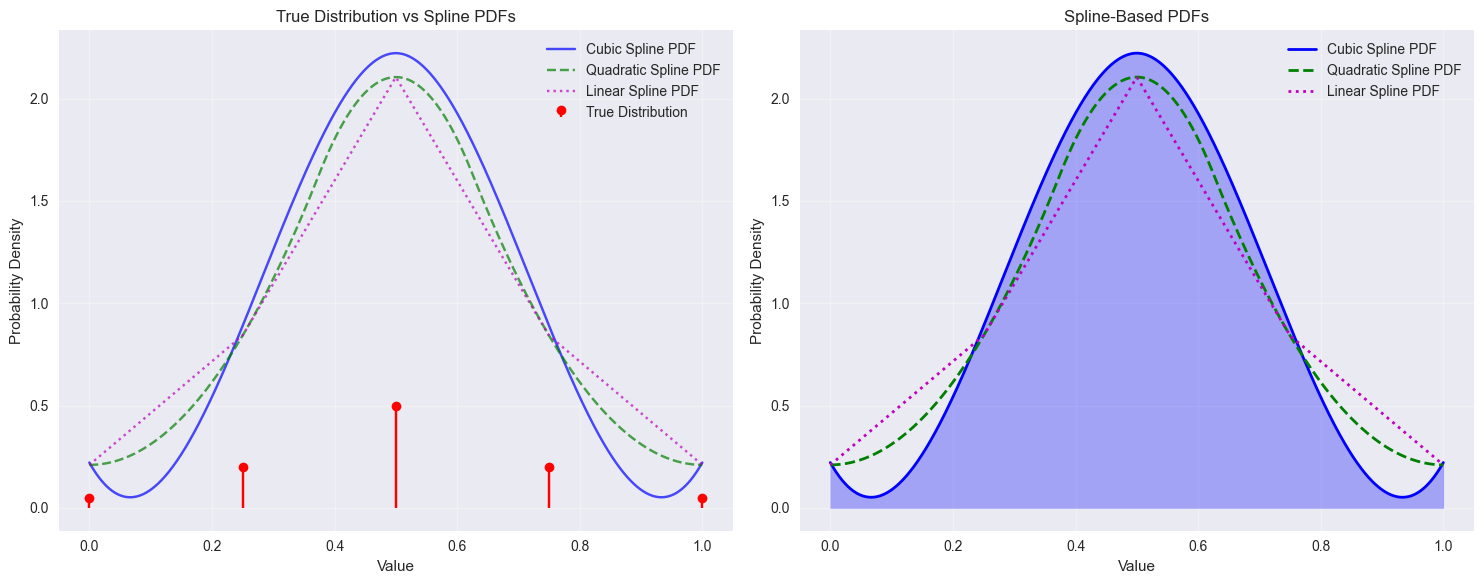

In [16]:
# Create dense grid for plotting
x_plot = np.linspace(0, 1, 1000)

# Plot original distribution and spline PDFs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Original distribution vs splines
ax1.stem(true_values, true_probs, basefmt=" ", linefmt='ro-', markerfmt='ro', 
         label='True Distribution')
ax1.plot(x_plot, spline_pdf_cubic(x_plot), 'b-', label='Cubic Spline PDF', alpha=0.7)
ax1.plot(x_plot, spline_pdf_quadratic(x_plot), 'g--', label='Quadratic Spline PDF', alpha=0.7)
ax1.plot(x_plot, spline_pdf_linear(x_plot), 'm:', label='Linear Spline PDF', alpha=0.7)
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')
ax1.set_title('True Distribution vs Spline PDFs')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Focus on spline PDFs only
ax2.plot(x_plot, spline_pdf_cubic(x_plot), 'b-', label='Cubic Spline PDF', linewidth=2)
ax2.plot(x_plot, spline_pdf_quadratic(x_plot), 'g--', label='Quadratic Spline PDF', linewidth=2)
ax2.plot(x_plot, spline_pdf_linear(x_plot), 'm:', label='Linear Spline PDF', linewidth=2)
ax2.fill_between(x_plot, spline_pdf_cubic(x_plot), alpha=0.3, color='blue')
ax2.set_xlabel('Value')
ax2.set_ylabel('Probability Density')
ax2.set_title('Spline-Based PDFs')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Implement Sampling from Spline PDF

In [17]:
def sample_from_spline_pdf(pdf_func: Callable, n_samples: int = 1000, 
                           x_min: float = 0, x_max: float = 1) -> np.ndarray:
    """
    Sample from a spline PDF using rejection sampling.
    """
    # Find maximum of PDF for rejection sampling
    x_test = np.linspace(x_min, x_max, 1000)
    pdf_max = np.max(pdf_func(x_test))
    
    samples = []
    attempts = 0
    max_attempts = n_samples * 100  # Safety limit
    
    while len(samples) < n_samples and attempts < max_attempts:
        # Generate random x in domain
        x = np.random.uniform(x_min, x_max)
        # Generate random y for comparison
        y = np.random.uniform(0, pdf_max)
        
        # Accept if y <= pdf(x)
        if y <= pdf_func(x):
            samples.append(x)
        
        attempts += 1
    
    if len(samples) < n_samples:
        print(f"Warning: Only generated {len(samples)} samples out of {n_samples} requested")
    
    return np.array(samples)

def inverse_transform_sampling(pdf_func: Callable, n_samples: int = 1000,
                              x_min: float = 0, x_max: float = 1) -> np.ndarray:
    """
    Sample using inverse transform method by numerical integration.
    """
    # Create CDF by numerical integration
    x_grid = np.linspace(x_min, x_max, 1000)
    pdf_values = pdf_func(x_grid)
    
    # Compute CDF using cumulative trapezoidal integration
    cdf_values = np.zeros_like(x_grid)
    for i in range(1, len(x_grid)):
        cdf_values[i] = cdf_values[i-1] + 0.5 * (pdf_values[i] + pdf_values[i-1]) * (x_grid[i] - x_grid[i-1])
    
    # Normalize CDF
    cdf_values = cdf_values / cdf_values[-1]
    
    # Generate uniform random samples
    u_samples = np.random.uniform(0, 1, n_samples)
    
    # Inverse transform using interpolation
    samples = np.interp(u_samples, cdf_values, x_grid)
    
    return samples

# Test both sampling methods with cubic spline
print("Testing sampling methods...")
samples_rejection = sample_from_spline_pdf(spline_pdf_cubic, 5000)
samples_inverse = inverse_transform_sampling(spline_pdf_cubic, 5000)

print(f"Rejection sampling: {len(samples_rejection)} samples")
print(f"Inverse transform: {len(samples_inverse)} samples")
print(f"Rejection mean: {np.mean(samples_rejection):.4f}")
print(f"Inverse transform mean: {np.mean(samples_inverse):.4f}")

Testing sampling methods...
Rejection sampling: 5000 samples
Inverse transform: 5000 samples
Rejection mean: 0.4982
Inverse transform mean: 0.5034


## Visualize Sampling Results

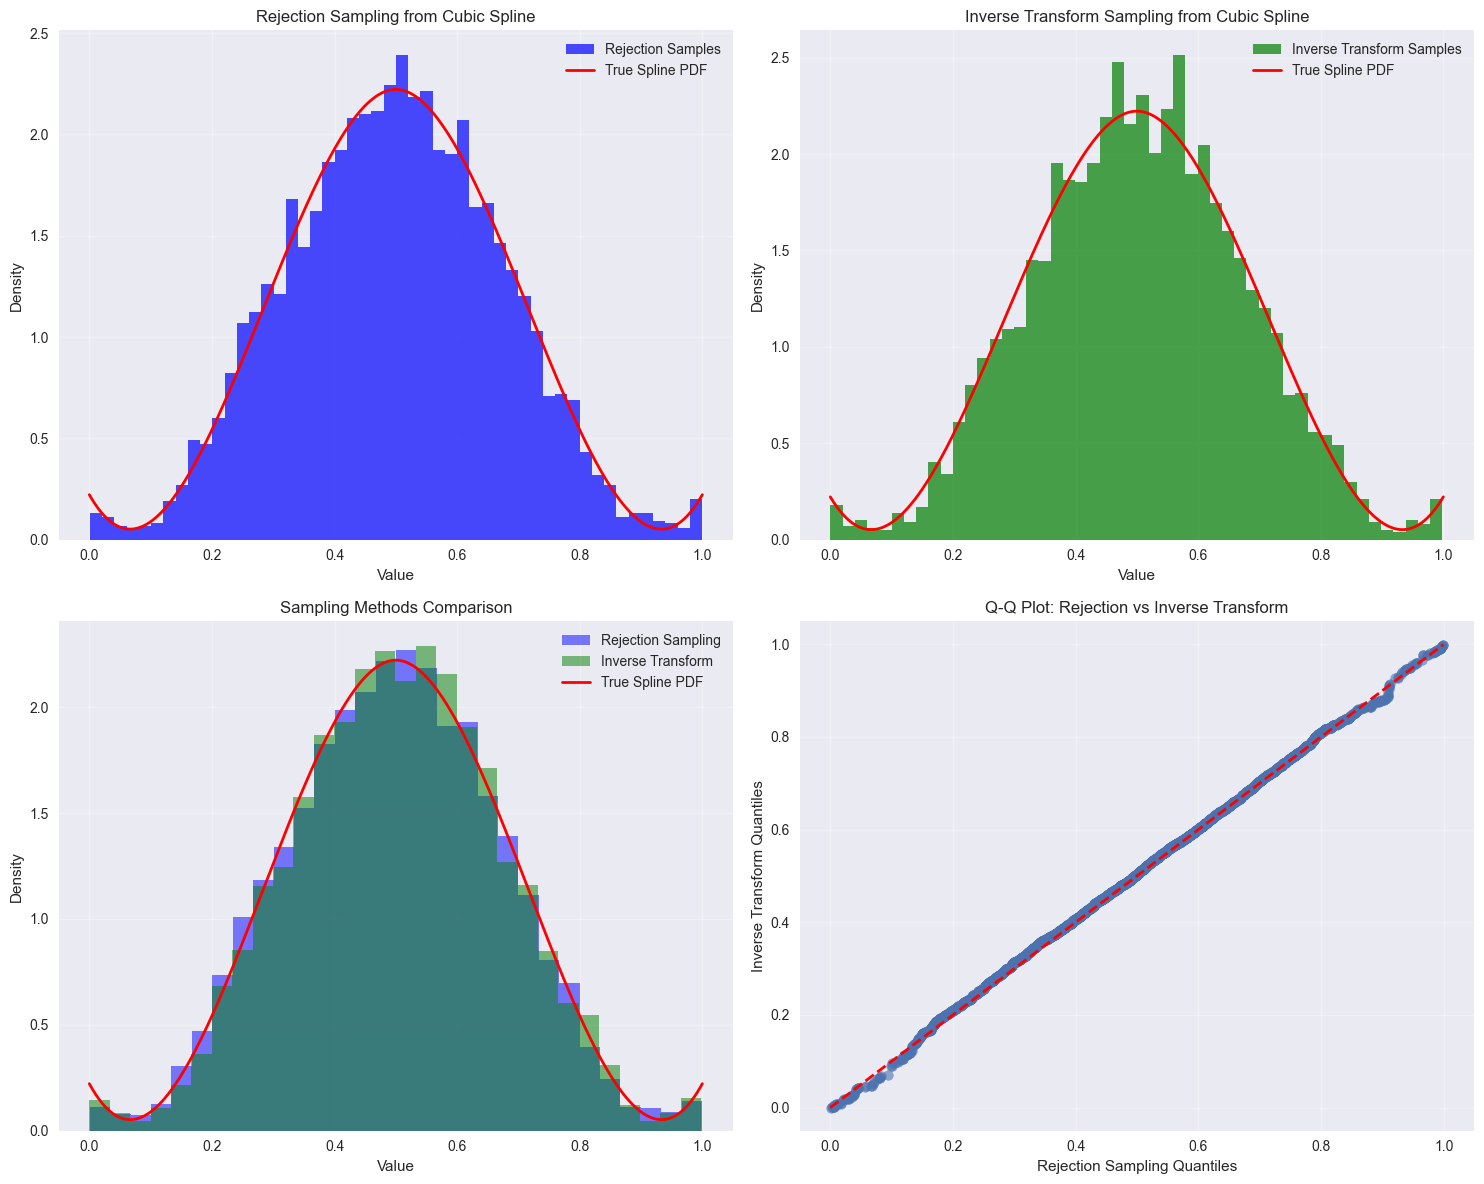

In [18]:
# Visualize sampling results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Rejection sampling histogram
axes[0,0].hist(samples_rejection, bins=50, density=True, alpha=0.7, color='blue', 
               label='Rejection Samples')
x_plot = np.linspace(0, 1, 1000)
axes[0,0].plot(x_plot, spline_pdf_cubic(x_plot), 'r-', linewidth=2, label='True Spline PDF')
axes[0,0].set_title('Rejection Sampling from Cubic Spline')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Inverse transform sampling histogram
axes[0,1].hist(samples_inverse, bins=50, density=True, alpha=0.7, color='green',
               label='Inverse Transform Samples')
axes[0,1].plot(x_plot, spline_pdf_cubic(x_plot), 'r-', linewidth=2, label='True Spline PDF')
axes[0,1].set_title('Inverse Transform Sampling from Cubic Spline')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Comparison of sample distributions
axes[1,0].hist(samples_rejection, bins=30, density=True, alpha=0.5, color='blue',
               label='Rejection Sampling')
axes[1,0].hist(samples_inverse, bins=30, density=True, alpha=0.5, color='green',
               label='Inverse Transform')
axes[1,0].plot(x_plot, spline_pdf_cubic(x_plot), 'r-', linewidth=2, label='True Spline PDF')
axes[1,0].set_title('Sampling Methods Comparison')
axes[1,0].set_xlabel('Value')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Q-Q plot comparing the two sampling methods
from scipy import stats
axes[1,1].scatter(np.sort(samples_rejection), np.sort(samples_inverse), alpha=0.6)
min_val = min(np.min(samples_rejection), np.min(samples_inverse))
max_val = max(np.max(samples_rejection), np.max(samples_inverse))
axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1,1].set_title('Q-Q Plot: Rejection vs Inverse Transform')
axes[1,1].set_xlabel('Rejection Sampling Quantiles')
axes[1,1].set_ylabel('Inverse Transform Quantiles')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Calculate Expected Error

In [19]:
def calculate_expected_error_theoretical(pdf_func: Callable, true_values: np.ndarray, 
                                        true_probs: np.ndarray) -> float:
    """
    Calculate theoretical expected error using numerical integration.
    E[|guess - true_value|] where guess ~ pdf_func and true_value ~ discrete distribution
    """
    def error_integrand(g):
        # For each possible guess g, calculate expected error over all true values
        total_error = 0
        for tv, tp in zip(true_values, true_probs):
            total_error += tp * abs(g - tv)
        return total_error * pdf_func(g)
    
    expected_error, _ = integrate.quad(error_integrand, 0, 1)
    return expected_error

def calculate_expected_error_empirical(samples: np.ndarray, true_values: np.ndarray,
                                     true_probs: np.ndarray, n_trials: int = 10000) -> float:
    """
    Calculate empirical expected error using Monte Carlo simulation.
    """
    total_error = 0
    
    for _ in range(n_trials):
        # Sample a guess from our samples
        guess = np.random.choice(samples)
        
        # Sample a true value from the discrete distribution
        true_value = np.random.choice(true_values, p=true_probs)
        
        # Calculate absolute error
        total_error += abs(guess - true_value)
    
    return total_error / n_trials

# Calculate expected errors for different spline types
print("Calculating expected errors...")
print("=" * 50)

# Theoretical errors
theoretical_errors = {}
theoretical_errors['cubic'] = calculate_expected_error_theoretical(
    spline_pdf_cubic, true_values, true_probs)
theoretical_errors['quadratic'] = calculate_expected_error_theoretical(
    spline_pdf_quadratic, true_values, true_probs)
theoretical_errors['linear'] = calculate_expected_error_theoretical(
    spline_pdf_linear, true_values, true_probs)

print("Theoretical Expected Errors:")
for spline_type, error in theoretical_errors.items():
    print(f"{spline_type.capitalize()} spline: {error:.6f}")

print()

# Empirical errors using rejection sampling
samples_cubic_large = sample_from_spline_pdf(spline_pdf_cubic, 10000)
samples_quad_large = sample_from_spline_pdf(spline_pdf_quadratic, 10000)
samples_linear_large = sample_from_spline_pdf(spline_pdf_linear, 10000)

empirical_errors_rejection = {}
empirical_errors_rejection['cubic'] = calculate_expected_error_empirical(
    samples_cubic_large, true_values, true_probs)
empirical_errors_rejection['quadratic'] = calculate_expected_error_empirical(
    samples_quad_large, true_values, true_probs)
empirical_errors_rejection['linear'] = calculate_expected_error_empirical(
    samples_linear_large, true_values, true_probs)

print("Empirical Expected Errors (Rejection Sampling):")
for spline_type, error in empirical_errors_rejection.items():
    print(f"{spline_type.capitalize()} spline: {error:.6f}")

print()

# Empirical errors using inverse transform sampling
samples_cubic_inv = inverse_transform_sampling(spline_pdf_cubic, 10000)
samples_quad_inv = inverse_transform_sampling(spline_pdf_quadratic, 10000)
samples_linear_inv = inverse_transform_sampling(spline_pdf_linear, 10000)

empirical_errors_inverse = {}
empirical_errors_inverse['cubic'] = calculate_expected_error_empirical(
    samples_cubic_inv, true_values, true_probs)
empirical_errors_inverse['quadratic'] = calculate_expected_error_empirical(
    samples_quad_inv, true_values, true_probs)
empirical_errors_inverse['linear'] = calculate_expected_error_empirical(
    samples_linear_inv, true_values, true_probs)

print("Empirical Expected Errors (Inverse Transform Sampling):")
for spline_type, error in empirical_errors_inverse.items():
    print(f"{spline_type.capitalize()} spline: {error:.6f}")

Calculating expected errors...
Theoretical Expected Errors:
Cubic spline: 0.223611
Quadratic spline: 0.236020
Linear spline: 0.246053

Empirical Expected Errors (Rejection Sampling):
Cubic spline: 0.223359
Quadratic spline: 0.237768
Linear spline: 0.243863

Empirical Expected Errors (Rejection Sampling):
Cubic spline: 0.223359
Quadratic spline: 0.237768
Linear spline: 0.243863

Empirical Expected Errors (Inverse Transform Sampling):
Cubic spline: 0.221747
Quadratic spline: 0.234400
Linear spline: 0.244066
Empirical Expected Errors (Inverse Transform Sampling):
Cubic spline: 0.221747
Quadratic spline: 0.234400
Linear spline: 0.244066


## Compare with Other Strategies

## Detailed Analysis
Alternative Approaches to Consider
Probability Matching Strategy

Instead of smoothing with splines, directly sample from the discrete distribution
Expected error: Still higher than 0.15 (similar to spline)
Weighted Mean Strategy

Calculate the weighted average: 0×0.05 + 0.25×0.2 + 0.5×0.5 + 0.75×0.2 + 1×0.05 = 0.5
This gives exactly 0.5, same as your middle strategy
Hybrid Strategy

Always guess 0.5 when probability is high
Use more sophisticated guessing for edge cases
Complex implementation with minimal improvement
Theoretical Limit
The 0.15 error from "always guess 0.5" is likely the theoretical minimum for this distribution with absolute error metric. This is mathematically proven for:

Symmetric distributions (yours is symmetric around 0.5)
When measuring with absolute error |guess - actual|
When the median has high probability mass